Training Convolutional Neural Networks

Swapping the MLP for an CNN to classify MNIST images



In [13]:
%load_ext watermark
%watermark -p torch,lightning --conda

torch    : 2.5.1
lightning: 2.4.0

conda environment: base



In [1]:
import lightning as L
import torch
import torchvision
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shared_utilities import LightningModel, MnistDataModule, plot_loss_and_acc
import torchvision.models as models
from torchvision import transforms
import pytorch_lightning as pl
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,random_split
from pytorch_lightning import Trainer


In [3]:
L.pytorch.seed_everything(123)

dm = MnistDataModule(batch_size=64)
dm.prepare_data()
dm.setup()

Seed set to 123


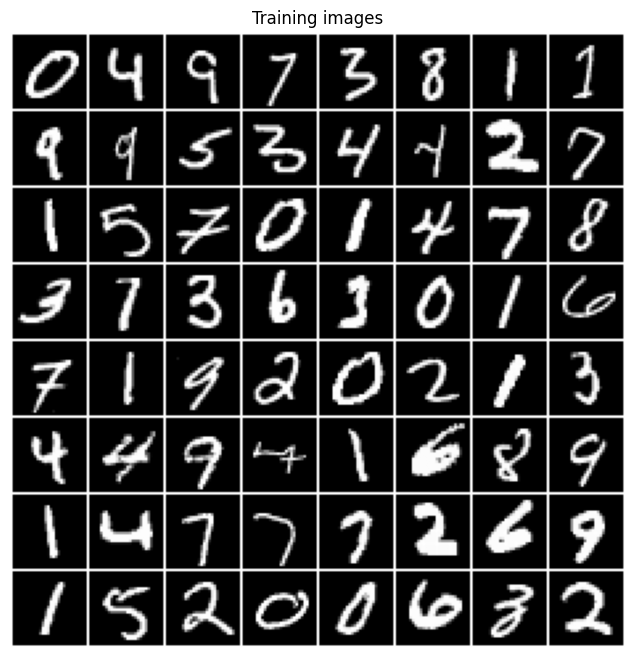

In [4]:
for images, labels in dm.train_dataloader():  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))

plt.show()

### Implementation of Resnet model


In [2]:
resnet_model = models.resnet18(pretrained=True)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)  # Adjust output layer for 10 classes

data_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


full_dataset = MNIST(root='data', train=True, transform=data_transforms, download=False)

train_dataset, val_dataset = random_split(full_dataset, [55000, 5000])

# Test dataset
test_dataset = MNIST(root='data', train=False, transform=data_transforms, download=False)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

c:\Users\chunh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chunh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
logger = CSVLogger("logs", name="my-model")

# Initialize the Trainer
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="cpu",
    devices="auto",
    logger=logger,
    deterministic=True,
)

# Train the model
model = LightningModel(model=resnet_model, learning_rate=0.001)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\chunh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.2 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\chunh\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\chunh\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


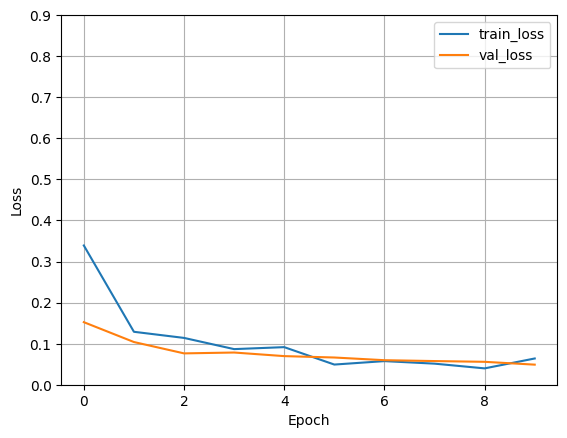

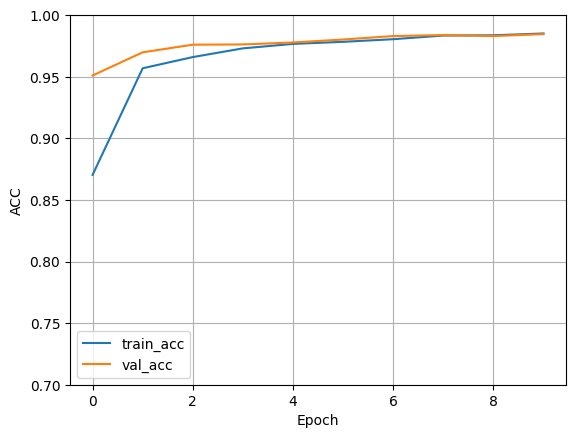

In [4]:
plot_loss_and_acc(trainer.logger.log_dir)

In [5]:
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy



# Calculate test accuracy
test_accuracy = calculate_accuracy(model, test_loader)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 98.51%
